## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from loss import SPOPlusLoss

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlusLoss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Evaluation 

In [6]:
def evalm(lr, dataloader):
    """
    evaluate model performence
    args:
      lr: linear regression model
      dataloader: dataloader from optDataSet
    """
    # evaluate
    lr.eval()
    # set SPO+ Loss as criterion
    criterion = SPOPlusLoss()
    loss = 0
    optsum = 0
    # load data
    for i, data in enumerate(dataloader):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        cp = lr(x)
        # accumulate loss
        loss += criterion.apply(sp_model, cp, c, w, z).sum().item()
        optsum += z.sum().item()
    # normalized
    print('Normalized SPO+ Loss: {:.2f}%'.format(loss / optsum * 100))
    return loss / optsum

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [7]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [8]:
# init DataFrame
df1 = pd.DataFrame(columns = [1, 2, 4, 6])

In [9]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-4 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=800, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [05:07<00:00,  2.60it/s]


Normalized SPO+ Loss: 2.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 310.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [05:01<00:00,  2.66it/s]


Normalized SPO+ Loss: 5.71%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.04it/s]


Normalized SPO+ Loss: 61.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 266.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:27<00:00,  3.00it/s]


Normalized SPO+ Loss: 270.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 381.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:17<00:00,  3.10it/s]


Normalized SPO+ Loss: 4.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:17<00:00,  3.11it/s]


Normalized SPO+ Loss: 10.42%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 314.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.40it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:23<00:00,  3.04it/s]


Normalized SPO+ Loss: 69.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:30<00:00,  2.96it/s]


Normalized SPO+ Loss: 317.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:28<00:00,  2.97it/s]


Normalized SPO+ Loss: 1.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 257.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:23<00:00,  3.04it/s]


Normalized SPO+ Loss: 6.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 293.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:25<00:00,  3.01it/s]


Normalized SPO+ Loss: 68.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


Normalized SPO+ Loss: 210.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 273.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:25<00:00,  3.01it/s]


Normalized SPO+ Loss: 1.68%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:30<00:00,  2.96it/s]


Normalized SPO+ Loss: 8.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 342.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.04it/s]


Normalized SPO+ Loss: 69.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.15it/s]


Normalized SPO+ Loss: 263.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:24<00:00,  3.03it/s]


Normalized SPO+ Loss: 1.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 354.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.40it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:09<00:00,  3.20it/s]


Normalized SPO+ Loss: 6.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 266.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]


Normalized SPO+ Loss: 47.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 323.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:17<00:00,  3.11it/s]


Normalized SPO+ Loss: 167.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.16it/s]


Normalized SPO+ Loss: 0.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


Normalized SPO+ Loss: 10.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.12it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:19<00:00,  3.08it/s]


Normalized SPO+ Loss: 86.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.15it/s]


Normalized SPO+ Loss: 361.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:06<00:00,  3.25it/s]


Normalized SPO+ Loss: 2.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:09<00:00,  3.21it/s]


Normalized SPO+ Loss: 7.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:19<00:00,  3.08it/s]


Normalized SPO+ Loss: 49.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:07<00:00,  3.23it/s]


Normalized SPO+ Loss: 187.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:07<00:00,  3.23it/s]


Normalized SPO+ Loss: 3.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 325.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:19<00:00,  3.09it/s]


Normalized SPO+ Loss: 11.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:07<00:00,  3.23it/s]


Normalized SPO+ Loss: 67.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.16it/s]


Normalized SPO+ Loss: 265.49%



Text(0, 0.5, 'Normalized SPO+ Loss')

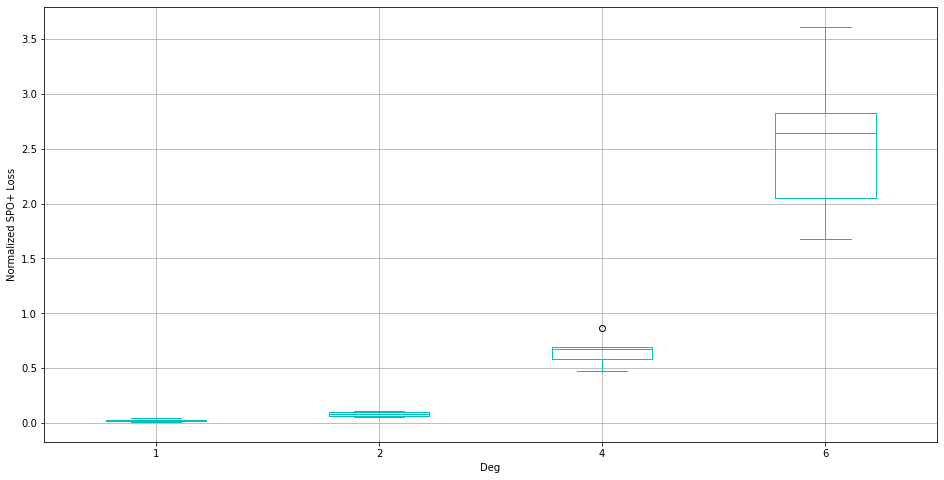

In [10]:
# draw boxplot
bplot = df1.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')

### Training Set Size = 100, Noise Half−width = 0.5

In [11]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [12]:
# init DataFrame
df2 = pd.DataFrame(columns = [1, 2, 4, 6])

In [13]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-4 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=800, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.16it/s]


Normalized SPO+ Loss: 3.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 293.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:17<00:00,  3.11it/s]


Normalized SPO+ Loss: 8.65%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:10<00:00,  3.19it/s]


Normalized SPO+ Loss: 58.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.27it/s]


Normalized SPO+ Loss: 278.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:06<00:00,  3.24it/s]


Normalized SPO+ Loss: 4.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 287.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.28it/s]


Normalized SPO+ Loss: 8.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.27it/s]


Normalized SPO+ Loss: 68.72%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 423.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:07<00:00,  3.24it/s]


Normalized SPO+ Loss: 316.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 396.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


Normalized SPO+ Loss: 1.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:12<00:00,  3.16it/s]


Normalized SPO+ Loss: 7.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 399.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.28it/s]


Normalized SPO+ Loss: 75.71%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:11<00:00,  3.18it/s]


Normalized SPO+ Loss: 221.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:06<00:00,  3.24it/s]


Normalized SPO+ Loss: 1.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.28it/s]


Normalized SPO+ Loss: 9.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 325.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:05<00:00,  3.25it/s]


Normalized SPO+ Loss: 78.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:02<00:00,  3.30it/s]


Normalized SPO+ Loss: 260.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 260.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:07<00:00,  3.23it/s]


Normalized SPO+ Loss: 1.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 289.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.27it/s]


Normalized SPO+ Loss: 6.71%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:08<00:00,  3.22it/s]


Normalized SPO+ Loss: 46.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 459.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:07<00:00,  3.23it/s]


Normalized SPO+ Loss: 173.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:12<00:00,  3.17it/s]


Normalized SPO+ Loss: 1.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [03:55<00:00,  3.39it/s]


Normalized SPO+ Loss: 12.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 303.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.27it/s]


Normalized SPO+ Loss: 88.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:09<00:00,  3.21it/s]


Normalized SPO+ Loss: 376.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.15it/s]


Normalized SPO+ Loss: 2.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 344.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:05<00:00,  3.27it/s]


Normalized SPO+ Loss: 8.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 354.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [03:59<00:00,  3.34it/s]


Normalized SPO+ Loss: 48.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:04<00:00,  3.27it/s]


Normalized SPO+ Loss: 185.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:10<00:00,  3.19it/s]


Normalized SPO+ Loss: 2.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.16it/s]


Normalized SPO+ Loss: 12.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:06<00:00,  3.25it/s]


Normalized SPO+ Loss: 77.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 800/800 [04:10<00:00,  3.20it/s]


Normalized SPO+ Loss: 255.03%



Text(0, 0.5, 'Normalized SPO+ Loss')

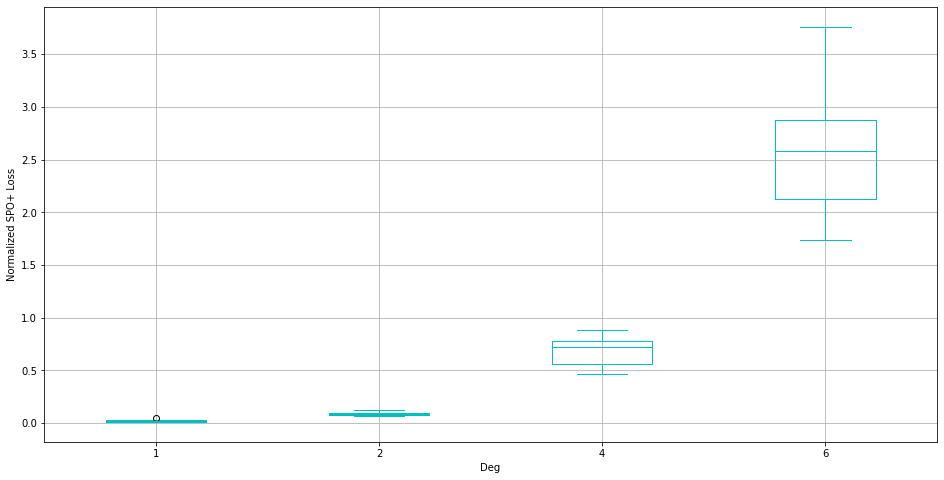

In [14]:
# draw boxplot
bplot = df2.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')

## Training Set Size = 1000, Noise Half−width = 0 

In [15]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [16]:
# init DataFrame
df3 = pd.DataFrame(columns = [1, 2, 4, 6])

In [17]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=100, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.02s/it]


Normalized SPO+ Loss: 0.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


Normalized SPO+ Loss: 5.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:55<00:00,  2.95s/it]


Normalized SPO+ Loss: 40.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:59<00:00,  3.00s/it]


Normalized SPO+ Loss: 167.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:01<00:00,  3.02s/it]


Normalized SPO+ Loss: 0.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.03s/it]


Normalized SPO+ Loss: 5.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.12it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:05<00:00,  3.05s/it]


Normalized SPO+ Loss: 48.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.04s/it]


Normalized SPO+ Loss: 265.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.06it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:00<00:00,  3.01s/it]


Normalized SPO+ Loss: 0.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:56<00:00,  2.96s/it]


Normalized SPO+ Loss: 5.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.03s/it]


Normalized SPO+ Loss: 47.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


Normalized SPO+ Loss: 174.93%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:36<00:00,  3.36s/it]


Normalized SPO+ Loss: 0.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:33<00:00,  3.34s/it]


Normalized SPO+ Loss: 5.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.98s/it]


Normalized SPO+ Loss: 54.20%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.11s/it]


Normalized SPO+ Loss: 204.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.03s/it]


Normalized SPO+ Loss: 0.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


Normalized SPO+ Loss: 5.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:07<00:00,  3.08s/it]


Normalized SPO+ Loss: 36.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:09<00:00,  3.10s/it]


Normalized SPO+ Loss: 156.91%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:59<00:00,  3.00s/it]


Normalized SPO+ Loss: 0.79%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:05<00:00,  3.05s/it]


Normalized SPO+ Loss: 8.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


Normalized SPO+ Loss: 57.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.11s/it]


Normalized SPO+ Loss: 264.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:16<00:00,  3.17s/it]


Normalized SPO+ Loss: 0.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.14s/it]


Normalized SPO+ Loss: 4.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:22<00:00,  3.22s/it]


Normalized SPO+ Loss: 40.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:24<00:00,  3.24s/it]


Normalized SPO+ Loss: 194.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.24s/it]


Normalized SPO+ Loss: 0.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.27s/it]


Normalized SPO+ Loss: 4.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:29<00:00,  3.29s/it]


Normalized SPO+ Loss: 38.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:38<00:00,  3.38s/it]


Normalized SPO+ Loss: 177.75%



Text(0, 0.5, 'Normalized SPO+ Loss')

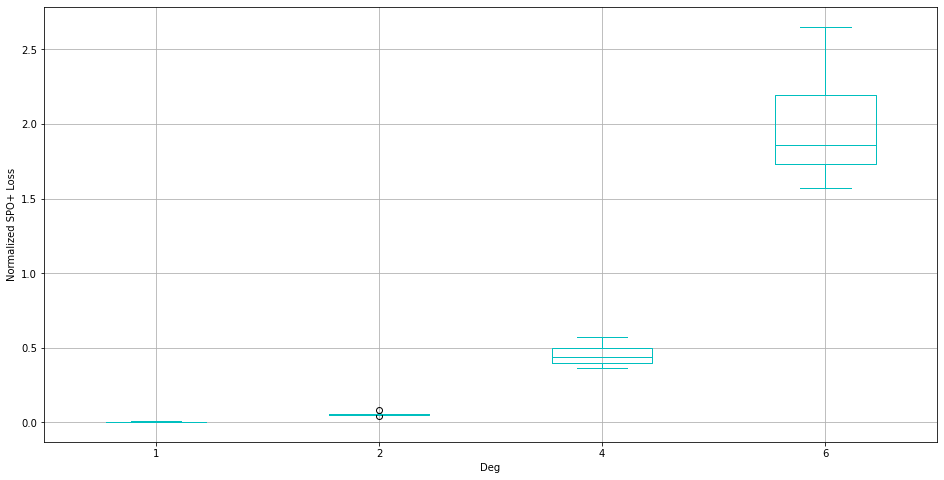

In [18]:
# draw boxplot
bplot = df3.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')

## Training Set Size = 1000, Noise Half−width = 0.5 

In [19]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [20]:
# init DataFrame
df4 = pd.DataFrame(columns = [1, 2, 4, 6])

In [21]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        lr = train(sp_loader_train, sp_model, num_epochs=100, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = evalm(lr, sp_loader_test)
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.24s/it]


Normalized SPO+ Loss: 0.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.11s/it]


Normalized SPO+ Loss: 6.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.17it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:15<00:00,  3.16s/it]


Normalized SPO+ Loss: 44.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:21<00:00,  3.21s/it]


Normalized SPO+ Loss: 180.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.24s/it]


Normalized SPO+ Loss: 0.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:15<00:00,  3.15s/it]


Normalized SPO+ Loss: 6.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.23s/it]


Normalized SPO+ Loss: 56.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:16<00:00,  3.16s/it]


Normalized SPO+ Loss: 265.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:29<00:00,  3.29s/it]


Normalized SPO+ Loss: 0.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:08<00:00,  3.08s/it]


Normalized SPO+ Loss: 6.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.18s/it]


Normalized SPO+ Loss: 47.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:29<00:00,  3.30s/it]


Normalized SPO+ Loss: 172.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:17<00:00,  3.17s/it]


Normalized SPO+ Loss: 0.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.26s/it]


Normalized SPO+ Loss: 6.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:14<00:00,  3.15s/it]


Normalized SPO+ Loss: 56.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:14<00:00,  3.15s/it]


Normalized SPO+ Loss: 216.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:08<00:00,  3.09s/it]


Normalized SPO+ Loss: 0.64%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:14<00:00,  3.14s/it]


Normalized SPO+ Loss: 5.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:00<00:00,  3.00s/it]


Normalized SPO+ Loss: 40.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 399.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.11s/it]


Normalized SPO+ Loss: 152.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.99s/it]


Normalized SPO+ Loss: 0.41%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.98s/it]


Normalized SPO+ Loss: 7.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.03s/it]


Normalized SPO+ Loss: 62.91%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:55<00:00,  2.95s/it]


Normalized SPO+ Loss: 268.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.03s/it]


Normalized SPO+ Loss: 0.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.02s/it]


Normalized SPO+ Loss: 5.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.93s/it]


Normalized SPO+ Loss: 40.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:07<00:00,  3.08s/it]


Normalized SPO+ Loss: 188.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.97s/it]


Normalized SPO+ Loss: 0.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


Normalized SPO+ Loss: 5.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.03s/it]


Normalized SPO+ Loss: 47.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:59<00:00,  3.00s/it]


Normalized SPO+ Loss: 191.79%



Text(0, 0.5, 'Normalized SPO+ Loss')

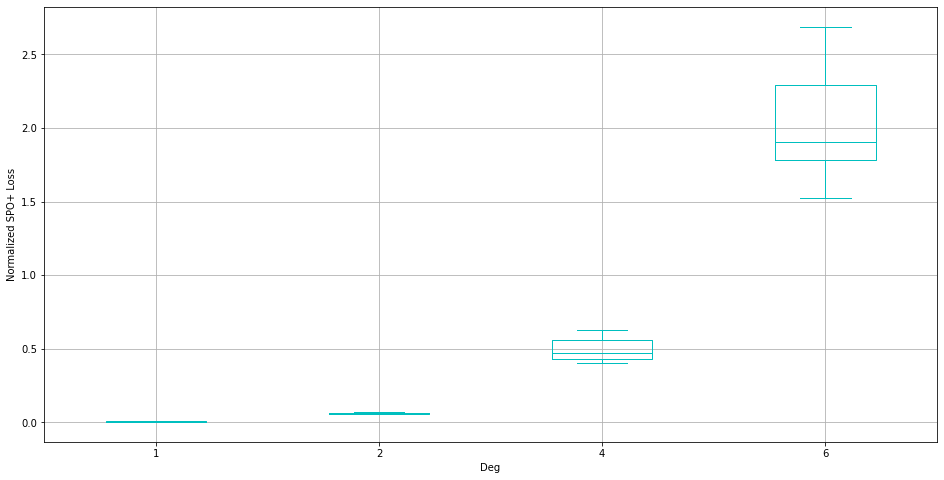

In [22]:
# draw boxplot
bplot = df4.boxplot(figsize=(16,8), color='c')
bplot.set_xlabel('Deg')
bplot.set_ylabel('Normalized SPO+ Loss')